# Rapport TAL - Partie Présidents

Membres du binôme :
- KRISNI Almehdi (3800519)
- ARICHANDRA Santhos (3802651)

### Introduction
Dans cette partie, nous allons nous intéresser à la prédiction de l'interlocuteur lors d'un débat présidentiel entre Chirac et Mitterrand. Entre d'autres termes, qui a dit quoi ?

Nous disposons donc d'une base de données d'apprentissage de 57000 lignes représentant un ensemble de phrases, chacune de ces dernières étiquetées par un C (Chirac) ou un M (Mitterrand), désignant la personne l'ayant prononcé. On peut alors labéliser notre ensemble d'apprentissage en 2 classes distinctes. 

Notre objectif est de mettre en place des algorithmes allant nous permettre de labelliser de nouveaux débats entre Chirac et Mitterrand.

### Mise en place des import et des librairies utilisées

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Pour retirer les messages d'alerte
import warnings
warnings.filterwarnings('ignore')

import codecs
import re
import os.path

import copy

# Librairies pour le traitement de texte
import re
import unicodedata
import string

# Librairie pour l'utilisation de compteurs
from collections import Counter

# Librairies pour le traitement de texte et la mise en place de vecteurs
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Librairies pour la phase de Machine Learning
import numpy as np
import sklearn.naive_bayes as nb
from sklearn import svm
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

# Libraires pour la récupération des stopwords et le stemming
from nltk.corpus import stopwords
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
cachedStopWords = stopwords.words("french") + (list(fr_stop))

# Libraire pour les statistiques (moyenne, ...)
import statistics

# Importation des librairies standards
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# Importation de votre librairie iads
import sys
sys.path.append('../')

# Iportation de utils
from iads import utils as ut

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

### Première analyse des données

On extrait dans un premier les informations à la base de données d'apprentissage. On utilise la fonction d'extraction "load_pres" située dans le fichier utils.py.

On considère 2 classes, la classe -1 représentant Mitterrand et la classe +1 représentant Chirac.

In [2]:
appdata = ut.load_pres("AFDpresidentutf8/corpus.tache1.learn.utf8")
appX = appdata[0]
appY = appdata[1]

On s'intéresse à la répartition des labels dans les données. Une personne parle-t-elle beaucoup plus que l'autre ?

In [3]:
print("Le nombre de lignes prononcées par Chirac :\t", str(appY.count(1)))
print("Le nombre de lignes prononcées par Mitterrand :\t", str(appY.count(-1)), "\n")
print("Proportion de Chirac dans la base d'apprentissage :\t", str((appY.count(1) / len(appY)) * 100), "%")
print("Proportion de Mitterrand dans la base d'apprentissage :\t", str((appY.count(-1) / len(appY)) * 100), "%")

Le nombre de lignes prononcées par Chirac :	 49890
Le nombre de lignes prononcées par Mitterrand :	 7523 

Proportion de Chirac dans la base d'apprentissage :	 86.89669587027329 %
Proportion de Mitterrand dans la base d'apprentissage :	 13.103304129726718 %


On remarque donc qu'il y a presque 87% des lignes dans la base de données d'apprentissage ayant été prononcées par Mitterrand. Il se peut que cette différence puisse jouer un rôle important lors de l'apprentissage.

### Nettoyage des données et analyse avancée

On effectue alors un premier nettoyage des données en supprimant les chiffres, la ponctuation, les accents, les majuscules et les stopwords de la langue française.

La liste des stopwords utilisés est la fusion entre la liste de la libraire nltk.stopwords et spacy.lang.fr.stop_words.

Le stemmer Snowball est tiré de la librairie nltk.stem.snowball.

In [4]:
appX = appdata[0]
appY = appdata[1]

In [5]:
print('\033[1m', "Sans aucune modification, on obtient comme premières lignes :",'\033[0m')
for s in appX[:5] :
    print("\t", s)
print()

test1AppX = ut.transform(appX, punc=True, accentMaj=True, nb=True, stopW=False, stem=False)
print('\033[1m', "Sans suppression des stopwords et sans stemming, on obtient comme premières lignes :",'\033[0m')
for s in test1AppX[:5] :
    print("\t", s)
print()

test2AppX = ut.transform(appX, punc=True, accentMaj=True, nb=True, stopW=True, stem=False)
print('\033[1m', "Avec suppression des stopwords et sans stemming, on obtient comme premières lignes :", '\033[0m')
for s in test2AppX[:5] :
    print("\t", s)
print()

test3AppX = ut.transform(appX, punc=True, accentMaj=True, nb=True, stopW=False, stem=True)
print('\033[1m', "Sans suppresion des stopwords et avec stemming, on obtient comme premières lignes :", '\033[0m')
for s in test3AppX[:5] :
    print("\t", s)
print()

test4AppX = ut.transform(appX, punc=True, accentMaj=True, nb=True, stopW=True, stem=True)
print('\033[1m', "Avec suppression des stopwords et un stemming, on obtient comme premières lignes :",'\033[0m')
for s in test4AppX[:5] :
    print("\t", s)

 Sans aucune modification, on obtient comme premières lignes : 
	  Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

	  D'abord merci de cet exceptionnel accueil que les Congolais, les Brazavillois, nous ont réservé cet après-midi.

	  C'est toujours très émouvant de venir en Afrique car c'est probablement l'une des rares terres du monde où l'on ait conservé cette convivialité, cette amitié, ce respect de l'autre qui s'expriment avec chaleur, avec spontanéité et qui réchauffent le coeur de ceux qui arrivent et de ceux qui reçoivent.

	  Aucun citoyen français ne peut être indifférent à un séjour à Brazzaville.

	  Le Congo, que naguère le <nom> qualifia de "refuge pour la liberté", de "base de départ pour la libération", de "môle pour la Résistance", comment ne pas être heureux de s'y retrouver ?


 Sans suppression des stopwords et sans stemming, on obtient comme premières lignes : 
	  quand je dis chers amis  il ne s 

On crée un Counter allant mettre en avant les mots les plus souvent utilisés par chacun des Présidents, après nettoyage des données en fonction des paramètres selectionnés.

In [6]:
# Création du dictionnaire et counter de mots de Mitterrand
motsM = [appX[i] for i in range(len(appY)) if appY[i] == -1]
motsM = (' '.join(motsM)).split()
counterM = Counter(motsM)

print("Les 10 mots les plus utilisés par Mitterrand sont :\n", [i[0] for i in counterM.most_common(10)], "\n")

# Creation du dictionnaire et counter de mots de Chirac
motsC = [appX[i] for i in range(len(appY)) if appY[i] == 1]
motsC = (' '.join(motsC)).split()
counterC = Counter(motsC)

print("Les 10 mots les plus utilisés par Chirac sont :\n", [i[0] for i in counterC.most_common(10)])

Les 10 mots les plus utilisés par Mitterrand sont :
 ['de', 'la', 'et', 'à', 'le', 'les', 'que', 'des', 'qui', 'en'] 

Les 10 mots les plus utilisés par Chirac sont :
 ['de', 'la', 'et', 'à', 'les', 'le', 'des', 'que', 'en', 'qui']


On remarque que les listes sont composées uniquement de stopwords. On décide donc de les supprimer afin d'avoir une meilleure idée des mots les plus utilisés par chaque Président.

In [7]:
# On supprime les stopwords
appX_ssw = ut.transform(appX, stopW=True)

# Création du dictionnaire et counter de mots de Mitterrand
motsM = [appX_ssw[i] for i in range(len(appY)) if appY[i] == -1]
motsM = (' '.join(motsM)).split()
counterM = Counter(motsM)

print("Les 10 mots les plus utilisés par Mitterrand sont :\n", [i[0] for i in counterM.most_common(10)], "\n")

# Creation du dictionnaire et counter de mots de Chirac
motsC = [appX_ssw[i] for i in range(len(appY)) if appY[i] == 1]
motsC = (' '.join(motsC)).split()
counterC = Counter(motsC)

print("Les 10 mots les plus utilisés par Chirac sont :\n", [i[0] for i in counterC.most_common(10)])

Les 10 mots les plus utilisés par Mitterrand sont :
 ['-', "c'est", 'Je', 'bien', 'pays', 'Il', "qu'il", ':', 'faut', 'France'] 

Les 10 mots les plus utilisés par Chirac sont :
 ['Je', "C'est", 'Il', 'France', "c'est", 'La', '<nom>', 'pays', ':', "d'une"]


On remarque une nouvelle fois que ces listes contiennent plusieurs mots avec des majuscules ou des signes de ponctuation. On décide donc de supprimer toutes les majuscules, tous les accents, tous les nombres et toute la ponctuation.

In [8]:
# On effectue la suppression totale
appX_ssw = ut.transform(appX, punc=True, accentMaj=True, nb=True, stopW=True)

# Création du dictionnaire et counter de mots de Mitterrand
motsM = [appX_ssw[i] for i in range(len(appY)) if appY[i] == -1]
motsM = (' '.join(motsM)).split()
counterM = Counter(motsM)

print("Les 10 mots les plus utilisés par Mitterrand sont :\n", [i[0] for i in counterM.most_common(10)], "\n")

# Creation du dictionnaire et counter de mots de Chirac
motsC = [appX_ssw[i] for i in range(len(appY)) if appY[i] == 1]
motsC = (' '.join(motsC)).split()
counterC = Counter(motsC)

print("Les 10 mots les plus utilisés par Chirac sont :\n", [i[0] for i in counterC.most_common(10)])

Les 10 mots les plus utilisés par Mitterrand sont :
 ['bien', 'pays', 'france', 'faut', 'europe', 'ete', 'nom', 'date', 'faire', 'temps'] 

Les 10 mots les plus utilisés par Chirac sont :
 ['france', 'pays', 'nom', 'aujourd', 'monde', 'francais', 'bien', 'europe', 'faire', 'etat']


In [9]:
# On crée de nouvelles variables pour simplifier le travail
all_M = [appX[i] for i in range(len(appY)) if appY[i] == -1]
all_C = [appX[i] for i in range(len(appY)) if appY[i] == 1]

txt_M = ut.transform(all_M, punc=True)
txt_M = ' '.join(txt_M)

txt_C = ut.transform(all_C, punc=True)
txt_C = ' '.join(txt_C)

In [10]:
vectorizerM = CountVectorizer(stop_words=cachedStopWords)
transform_VM = vectorizerM.fit_transform(all_M)
mots_uniques_M = vectorizerM.get_feature_names()
print('Nombre de mots uniques M =>',len(vectorizerM.get_feature_names()))

Nombre de mots uniques M => 13376


In [11]:
nb_occurs_M = np.sum(transform_VM.toarray(), axis=0)
counterM = Counter( { mots_uniques_M[i] : nb_occurs_M[i] for i in range(len(mots_uniques_M)) } )
counterM.most_common(50)

[('bien', 827),
 ('pays', 822),
 ('france', 743),
 ('faut', 587),
 ('europe', 559),
 ('nom', 444),
 ('date', 384),
 ('faire', 379),
 ('temps', 313),
 ('monde', 294),
 ('aujourd', 284),
 ('beaucoup', 275),
 ('français', 249),
 ('vie', 235),
 ('histoire', 232),
 ('ici', 230),
 ('politique', 229),
 ('etat', 222),
 ('non', 208),
 ('communauté', 183),
 ('années', 181),
 ('fois', 180),
 ('ans', 174),
 ('ensemble', 171),
 ('président', 170),
 ('part', 169),
 ('crois', 167),
 ('droit', 167),
 ('développement', 167),
 ('point', 163),
 ('hommes', 161),
 ('cas', 158),
 ('grande', 158),
 ('grand', 153),
 ('moyens', 145),
 ('monsieur', 142),
 ('grands', 138),
 ('région', 138),
 ('etats', 137),
 ('simplement', 137),
 ('société', 136),
 ('ville', 134),
 ('république', 133),
 ('moment', 132),
 ('plan', 129),
 ('esprit', 128),
 ('gouvernement', 127),
 ('économique', 127),
 ('guerre', 126),
 ('peuple', 125)]

In [12]:
vectorizerC = CountVectorizer(stop_words=cachedStopWords)
transform_VC = vectorizerC.fit_transform(all_C)
mots_uniques_C = vectorizerC.get_feature_names()
print('Nombre de mots uniques C =>',len(vectorizerC.get_feature_names()))

Nombre de mots uniques C => 24954


In [13]:
nb_occurs_C = np.sum(transform_VC.toarray(), axis=0)
counterC = Counter( { mots_uniques_C[i] : nb_occurs_C[i] for i in range(len(mots_uniques_C)) } )
counterC.most_common(50)

[('france', 4458),
 ('pays', 3642),
 ('nom', 3086),
 ('aujourd', 2297),
 ('monde', 2198),
 ('français', 2122),
 ('bien', 2118),
 ('europe', 2050),
 ('faire', 2047),
 ('date', 1567),
 ('faut', 1530),
 ('ensemble', 1501),
 ('développement', 1460),
 ('monsieur', 1389),
 ('président', 1367),
 ('politique', 1308),
 ('vie', 1238),
 ('avenir', 1143),
 ('union', 1143),
 ('paix', 1134),
 ('ici', 1118),
 ('européenne', 1090),
 ('etat', 1041),
 ('temps', 1036),
 ('sécurité', 1007),
 ('ans', 998),
 ('économique', 997),
 ('devons', 995),
 ('place', 982),
 ('société', 939),
 ('entreprises', 938),
 ('beaucoup', 922),
 ('grande', 918),
 ('contre', 900),
 ('action', 882),
 ('histoire', 881),
 ('mieux', 881),
 ('grand', 875),
 ('jeunes', 809),
 ('travail', 808),
 ('respect', 807),
 ('solidarité', 806),
 ('coeur', 801),
 ('dialogue', 784),
 ('volonté', 784),
 ('confiance', 778),
 ('service', 769),
 ('fois', 764),
 ('droit', 762),
 ('démocratie', 754)]

In [14]:
# On retire les mots en communs des dictionnaires de chaque Président
removeWords = ut.remove_same(50,counterC,counterM)
removeWords

['histoire',
 'vie',
 'économique',
 'temps',
 'pays',
 'aujourd',
 'bien',
 'grande',
 'monde',
 'faut',
 'etat',
 'droit',
 'ici',
 'fois',
 'beaucoup',
 'nom',
 'ans',
 'développement',
 'français',
 'politique',
 'société',
 'france',
 'europe',
 'ensemble',
 'grand',
 'faire',
 'monsieur',
 'président',
 'date']

In [15]:
# Nouvelle liste de stopwords allant être utilisée par la suite
newSW = cachedStopWords + removeWords

On obtient désormais des listes de mots plus compréhensibles mais on remarque tout de même une similarité parmi les mots employés par les deux Présidents.

On s'intéresse alors à mettre en place deux dictionnaires exclusifs pour Chirac et Mitterrand. Il s'agit de dictionnaires comportant les mots qu'ils utilisent de manière exclusive.

In [16]:
# Dictionnaire exclusif de Mitterrand
excluM = copy.deepcopy(counterM)
for w in counterC.keys() :
    if w in excluM.keys() :
        del excluM[w]
        
print("Le ratio de mots exclusifs utilisés par Mitterrand est de :\t", len(excluM.keys()) / len(counterM.keys()))
print("Les 30 mots exclusifs les plus utilisés par Mitterrand sont :\n", [i[0] for i in excluM.most_common(30)], "\n")

# Dictionnaire exclusif de Chirac
excluC = copy.deepcopy(counterC)
for w in counterM.keys() :
    if w in excluC.keys() :
        del excluC[w]
        
print("Le ratio de mots exclusifs utilisés par Chirac est de :\t\t", len(excluC.keys()) / len(counterC.keys()))
print("Les 30 mots exclusifs les plus utilisés par Chirac sont :\n", [i[0] for i in excluC.most_common(30)])

Le ratio de mots exclusifs utilisés par Mitterrand est de :	 0.23444976076555024
Les 30 mots exclusifs les plus utilisés par Mitterrand sont :
 ['320', 'convenait', 'nièvre', 'eurêka', 'cee', 'estampes', 'morvan', 'laitiers', 'nevers', 'électrification', '340', 'dédain', 'définitions', 'montluçon', 'vocabulaire', '500000', 'disposés', 'figeac', 'guadeloupéen', 'songez', 'étonné', '10000', '100000', '125000', 'banc', 'basques', 'bougent', 'buffon', 'cantal', 'carrément'] 

Le ratio de mots exclusifs utilisés par Chirac est de :		 0.5896449467019316
Les 30 mots exclusifs les plus utilisés par Chirac sont :
 ['mondialisation', 'euro', '000', 'attentes', 'g8', 'constituent', 'guyane', 'mercosur', 'sida', 'respectueux', 'internet', 'verre', 'probablement', 'superbe', 'chaleureusement', 'laïcité', 'handicapées', 'gendarmerie', 'gouvernance', 'xxie', 'indien', 'multipolaire', 'méditerranéen', 'socle', 'associatif', 'pompiers', 'champions', 'croissant', 'mayotte', 'présidente']


### Modèles de Machine Learning selectionnés

Nous avons choisi d'utiliser les principaux modèles vus en cours et en TME, c'est-à-dire :
- SVM linéaire (LinearSVC)
- Naive Bayes (MultinomialNB)
- régression logistique (LogisticRegression)

Nous utiliserons donc la libraire sklearn puisqu'elle propose tous ces modèles. On importe tous les composants nécessaires de la librairie et d'autres élements utiles.

In [17]:
# Import des modèles utilisés
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Import de librairies pour le temps et la validation
import time
from sklearn.model_selection import cross_validate, cross_val_score, KFold

# Import de libraires pour la mise en forme du texte
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Afin d'utiliser les données, il faut les mettre sous forme vectorielle.

In [18]:
# Utilisation de la libraire CountVectorizer
vectPres = CountVectorizer()
Xpres = vectPres.fit_transform(appX)
Ypres = appY

## Première campagne d'expériences

Durant notre première campagne, nous nous sommes intéressés uniquement à l'utilisation des différents modèles en faisant varier quelques paramètres afin d'obtenir les meilleurs résultats comme l'utilisation ou non de la validation croisée, le nombre d'ensemble et le mélange ou non des données.

### Utilisation du modèle SVM linéaire (LinearSVC)

##### Sans validation croisée

In [19]:
# Création du classifieur
svc = LinearSVC(max_iter=1000)
svc.fit(Xpres, Ypres)

# Liste pour sauvegarder les scores de précision
resultSVM = []

# Score sur les données
res = svc.score(Xpres, Ypres)

# Affichage des informations
print("Score sur les données d'entraînement :", res)
print('Nombre de paramètres vecteur de poids du SVM :', len(svc.coef_[0]),'\nVecteur de poids du SVM :', svc.coef_)

Score sur les données d'entraînement : 0.976294567432463
Nombre de paramètres vecteur de poids du SVM : 28524 
Vecteur de poids du SVM : [[ 1.55615396 -0.22590646  0.39057445 ... -0.33421285  0.
  -0.42601779]]


##### Validation croisée, KFold à n = 5, sans mélange

In [20]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
svc = LinearSVC(max_iter=1000)

# KFold permet de créer des sous-ensemble de données tel que à chaque itération, les sous-ensembles ait le même format
# Il s'agit de l'équivalent de la fonction de validation croisée que l'on trouve dans le fichier iads/utils.py
# https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Nevertheless%2C%20the%20KFold%20class%20can,with%20very%20large%20data%20samples.
kfold = KFold(n_splits=5, shuffle=False)

# Un fit est effectué lors de l'appel de la fonction cross_val_score
scores_cv = cross_val_score(svc, Xpres, Ypres, cv=kfold)
resultSVM.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.8582252  0.86972046 0.87990943 0.89487894 0.89026302] 
Précision moyenne = 0.87860


##### Validation croisée, KFold à n = 10, sans mélange

In [21]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
svc = LinearSVC(max_iter=1000)

kfold = KFold(n_splits=10, shuffle=False)
scores_cv = cross_val_score(svc, Xpres, Ypres, cv=kfold)
resultSVM.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.84343434 0.87513062 0.87008011 0.86918655 0.88016025 0.88416652
 0.9014109  0.89705626 0.89078558 0.89200488] 
Précision moyenne = 0.88034


##### Validation croisée, KFold à n = 5, avec mélange

In [22]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
svc = LinearSVC(max_iter=1000)

kfold = KFold(n_splits=5, shuffle=True)
scores_cv = cross_val_score(svc, Xpres, Ypres, cv=kfold)
resultSVM.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.88330576 0.8853958  0.88853087 0.88590838 0.89165651] 
Précision moyenne = 0.88696


##### Validation croisée, KFold à n = 10, avec mélange

In [23]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
clf = LinearSVC(max_iter=1000)

kfold = KFold(n_splits=10, shuffle=True)
scores_cv = cross_val_score(clf, Xpres, Ypres, cv=kfold)
resultSVM.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.88975967 0.89010798 0.89376524 0.89026302 0.88416652 0.89217906
 0.88747605 0.88016025 0.88643094 0.89200488] 
Précision moyenne = 0.88863


### Utilisation du modèle Naive Bayes (MultinomialNB)

#### Sans validation croisée

In [24]:
# Création du classifieur
clf = MultinomialNB()
clf.fit(Xpres, Ypres)

# Liste pour sauvegarder les scores de précision
resultNB = []

# Score sur les données
print("Score sur les données d'entraînement :", clf.score(Xpres, Ypres))
print('Nombre de paramètres vecteur de poids du SVM :', len(clf.coef_[0]),'\nVecteur de poids du SVM :', clf.coef_)

Score sur les données d'entraînement : 0.9158030411230906
Nombre de paramètres vecteur de poids du SVM : 28524 
Vecteur de poids du SVM : [[ -8.48585104  -9.69294397 -10.3553195  ... -13.85182706 -13.85182706
  -13.85182706]]


##### Validation croisée, KFold à n = 5, sans mélange

In [25]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
clf = MultinomialNB()

kfold = KFold(n_splits=5, shuffle=False)
scores_cv = cross_val_score(clf, Xpres, Ypres, cv=kfold)
resultNB.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.85927023 0.8664983  0.87929983 0.89757882 0.88033444] 
Précision moyenne = 0.87660


##### Validation croisée, KFold à n = 10, sans mélange

In [26]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
clf = MultinomialNB()

kfold = KFold(n_splits=10, shuffle=False)
scores_cv = cross_val_score(clf, Xpres, Ypres, cv=kfold)
resultNB.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.84691745 0.87600139 0.87617555 0.86204494 0.88416652 0.87632817
 0.90175928 0.89148232 0.87772165 0.88346978] 
Précision moyenne = 0.87761


##### Validation croisée, KFold à n = 5, avec mélange

In [27]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
clf = MultinomialNB()

kfold = KFold(n_splits=5, shuffle=True)
scores_cv = cross_val_score(clf, Xpres, Ypres, cv=kfold)
resultNB.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.88583123 0.88234782 0.88591831 0.88634384 0.89008883] 
Précision moyenne = 0.88611


##### Validation croisée, KFold à n = 10, avec mélange

In [28]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
clf = MultinomialNB()

kfold = KFold(n_splits=10, shuffle=True)
scores_cv = cross_val_score(clf, Xpres, Ypres, cv=kfold)
resultNB.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.88018112 0.88819227 0.88192268 0.89078558 0.88399234 0.88712768
 0.89322418 0.88242466 0.88660512 0.88486326] 
Précision moyenne = 0.88593


### Utilisation du modèle de Regression Logistique (LogisticRegression)

#### Sans validation croisée

In [29]:
# Création du classifieur
lin = LogisticRegression(max_iter=1000)
lin.fit(Xpres, Ypres)

# Liste pour sauvegarder les scores de précision
resultLR = []

# Score sur les données
print("Score sur les données d'entraînement :", lin.score(Xpres, Ypres))
print('Nombre de paramètres vecteur de poids du SVM :', len(lin.coef_[0]),'\nVecteur de poids du SVM :', lin.coef_)

Score sur les données d'entraînement : 0.9445247592008779
Nombre de paramètres vecteur de poids du SVM : 28524 
Vecteur de poids du SVM : [[ 2.34071287 -0.52287388  0.1321818  ... -0.37183033 -0.02149614
  -0.22525139]]


##### Validation croisée, KFold à n = 5, sans mélange

In [30]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
lin = LogisticRegression(max_iter=1000)

kfold = KFold(n_splits=5, shuffle=False)
scores_cv = cross_val_score(lin, Xpres, Ypres, cv=kfold)
resultLR.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.86902377 0.88530872 0.90072281 0.91761017 0.91038147] 
Précision moyenne = 0.89661


##### Validation croisée, KFold à n = 10,  sans mélange

In [31]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
lin = LogisticRegression(max_iter=1000)

kfold = KFold(n_splits=10, shuffle=False)
scores_cv = cross_val_score(lin, Xpres, Ypres, cv=kfold)
resultLR.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.85127133 0.8908046  0.88801811 0.88573419 0.89844975 0.9026302
 0.92179063 0.91534576 0.91203623 0.91081693] 
Précision moyenne = 0.89769


##### Validation croisée, KFold à n = 5, avec mélange

In [32]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
lin = LogisticRegression(max_iter=1000)

kfold = KFold(n_splits=5, shuffle=True)
scores_cv = cross_val_score(lin, Xpres, Ypres, cv=kfold)
resultLR.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.89941653 0.90446747 0.90342245 0.9039366  0.90219474] 
Précision moyenne = 0.90269


##### Validation croisée, KFold à n = 10, avec mélange

In [33]:
# Prédictions en utilisant la validation croisée sans mélange des données d'apprentissage
lin = LogisticRegression(max_iter=1000)

kfold = KFold(n_splits=10, shuffle=True)
scores_cv = cross_val_score(lin, Xpres, Ypres, cv=kfold)
resultLR.append(1 - statistics.mean(scores_cv))

print("Score sur les données d'entraînement:", scores_cv, "\nPrécision moyenne = %.5f" % statistics.mean(scores_cv))

Score sur les données d'entraînement: [0.90491118 0.90142807 0.90456287 0.90193346 0.90193346 0.91203623
 0.90332695 0.90193346 0.89740463 0.91012019] 
Précision moyenne = 0.90396


### Affichage et comparaisons des données

Maintenant que nous avons récupérer tous les scores de précision moyenne, nous allons désormais les comparer afin de réaliser de premières observations.

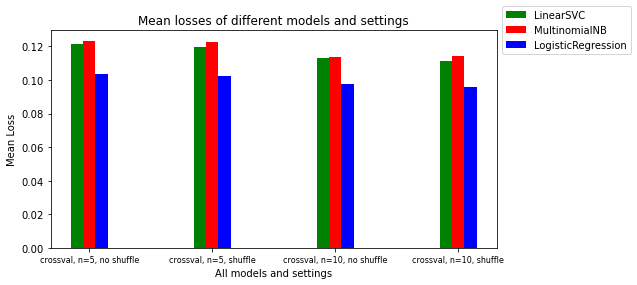

In [34]:
# Regroupement des résultats
xlabels = ["crossval, n=5, no shuffle", "crossval, n=5, shuffle", 
           "crossval, n=10, no shuffle", "crossval, n=10, shuffle"]
x = np.arange(4)

# Création du graphique
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)

# Mise en place des informations
ax.bar(x - 0.1, resultSVM, width=0.1, color='g', align='center', label="LinearSVC")
ax.bar(x, resultNB, width=0.1, color='r', align='center', label="MultinomialNB")
ax.bar(x + 0.1, resultLR, width=0.1, color='b', align='center', label="LogisticRegression")
ax.set_xlabel('All models and settings', fontsize=10)
ax.set_ylabel('Mean Loss', fontsize=10)
plt.title('Mean losses of different models and settings')
plt.xticks(x, xlabels, fontsize=8)

# Mise en place de la légende
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# Affichage et sauvegarde
plt.savefig('plot/first_exp_cmp.png', bbox_inches='tight')

On remarque que le modèle le plus précis est la Regression Logistique, puisque son taux d'erreur moyen est constamment inférieur ou égal à 10%. On remarque tout de même qu'en augmentant le nombre d'itérations sur la validation croisée et en mélangeant les données, on obtient une baisse constante de l'erreur moyenne.

La base de données utilisée n'a pas été transformée afin de supprimer toutes les majuscules, ponctuation, nombres et autres. On décide d'effectuer de nouvelles séries de tests en les supprimant et en utilisant oui ou non les racines de mots.

In [35]:
# On effectue une nouvelle expérience avec la suppression des stopwords et la mise en forme des mots, mais sans les racines
Xpres = ut.transform(appX, punc=True, accentMaj=True, nb=True, stopW=True)

In [36]:
# Transformation en vecteurs
vectPres = CountVectorizer()
Xpres = vectPres.fit_transform(Xpres)
Ypres = appY
resultSVM, resultNB, resultLR = ut.quickTest(Xpres, Ypres)

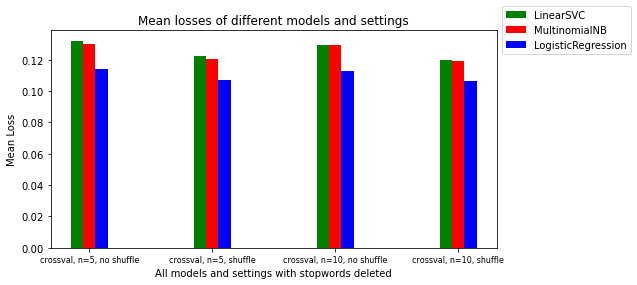

In [37]:
# Regroupement des résultats
xlabels = ["crossval, n=5, no shuffle", "crossval, n=5, shuffle", 
           "crossval, n=10, no shuffle", "crossval, n=10, shuffle"]
x = np.arange(4)

# Création du graphique
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)

# Mise en place des informations
ax.bar(x - 0.1, resultSVM, width=0.1, color='g', align='center', label="LinearSVC")
ax.bar(x, resultNB, width=0.1, color='r', align='center', label="MultinomialNB")
ax.bar(x + 0.1, resultLR, width=0.1, color='b', align='center', label="LogisticRegression")
ax.set_xlabel('All models and settings with stopwords deleted', fontsize=10)
ax.set_ylabel('Mean Loss', fontsize=10)
plt.title('Mean losses of different models and settings')
plt.xticks(x, xlabels, fontsize=8)

# Mise en place de la légende
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# Affichage et sauvegarde
plt.savefig('plot/first_exp_cmp_fulldelete_nostemming.png', bbox_inches='tight')

On remarque que les résultats sont en moyenne un peu moins bon que les résultats précedents. On décide alors d'utiliser les racines lors de la transformation du texte.

In [38]:
# On effectue une nouvelle expérience avec la suppression des stopwords et la mise en forme des mots et avec les racines
Xpres = ut.transform(appX, punc=True, accentMaj=True, nb=True, stopW=True, stem=True)

In [39]:
# Transformation en vecteurs
vectPres = CountVectorizer()
Xpres = vectPres.fit_transform(Xpres)
Ypres = appY
resultSVM, resultNB, resultLR = ut.quickTest(Xpres, Ypres)

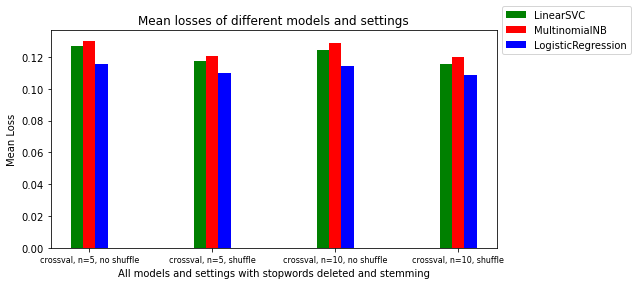

In [40]:
# Regroupement des résultats
xlabels = ["crossval, n=5, no shuffle", "crossval, n=5, shuffle", 
           "crossval, n=10, no shuffle", "crossval, n=10, shuffle"]
x = np.arange(4)

# Création du graphique
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)

# Mise en place des informations
ax.bar(x - 0.1, resultSVM, width=0.1, color='g', align='center', label="LinearSVC")
ax.bar(x, resultNB, width=0.1, color='r', align='center', label="MultinomialNB")
ax.bar(x + 0.1, resultLR, width=0.1, color='b', align='center', label="LogisticRegression")
ax.set_xlabel('All models and settings with stopwords deleted and stemming', fontsize=10)
ax.set_ylabel('Mean Loss', fontsize=10)
plt.title('Mean losses of different models and settings')
plt.xticks(x, xlabels, fontsize=8)

# Mise en place de la légende
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# Affichage et sauvegarde
plt.savefig('plot/first_exp_cmp_fulldelete_with_stemming.png', bbox_inches='tight')

## Deuxième campagne d'expériences

Nous avons évoqué précedemment le fait que chaque Président utilise plus souvent certains mots que d'autres et le fait que nous avons beaucoup plus de données d'apprentissage pour Chirac que pour Mitterrand.

On cherche donc à mettre en place un algorithme utilisant les odds-ratio afin de mettre en avant une liaison entre le fait qu'un Président utilise plus souvent un mot que l'autre. On utilise un biais afin de representer le fait que Mitterrand ait prononcé beaucoup moins de chose que Chirac dans la base d'apprentissage.

In [41]:
# On parcourt chaque ligne et on étudie la probabilité qu'un Président l'ait prononcé en fonction des mots exclusifs
newtext = ut.transform(appX, punc=True, stopW=True, base=newSW)

In [42]:
# Liste des predictions
pred = []
biais = 2.5

# On parcourt le texte
for i in range(len(newtext)) :
    nt = newtext[i].split()
    scoreC = 0
    scoreM = 0
    
    for w in nt :
        if counterC[w] > counterM[w] * biais :
            scoreC += 1
        else :
            scoreM += 1
            
    if scoreM > scoreC :
        pred.append(-1)
    elif scoreM < scoreC :
        pred.append(1)
    else :
        pred.append(0)

score = 0
for i in range(len(pred)) :
    if pred[i] == appY[i] :
        score += 1
print("Score de prévision avec un biais de ", biais, ":", score / len(pred))

Score de prévision avec un biais de  2.5 : 0.7854318708306481


On pourrait penser que cette méthode de prédiction puisse être intéressante vu que le score de prédiction est assez intéressant lorsqu'on joue un peu avec le biais (pour un biais de 2.5, on a un score de 0.78) et plus on le réduit, plus le score de prédiction augmente. Mais en réalité, on ne fait que mieux classer les données de Chirac et on délaisse les données de Mitterrand.

Du fait que l'on dispose de presque six fois plus de données Chirac (87%) que Mitterrand (13%), si on continue à réduire le biais, on finira par approcher une limite de 87% de précision en raison de la répartition des données. De même, si on augmentait le biais à l'infini, on convergerait vers une limite de 13% de précision.

In [43]:
# Liste des predictions
pred = []
biais = 1e-5

# On parcourt le texte
for i in range(len(newtext)) :
    nt = newtext[i].split()
    scoreC = 0
    scoreM = 0
    
    for w in nt :
        if counterC[w] > counterM[w] * biais :
            scoreC += 1
        else :
            scoreM += 1
            
    if scoreM > scoreC :
        pred.append(-1)
    elif scoreM < scoreC :
        pred.append(1)
    else :
        pred.append(0)

score = 0
for i in range(len(pred)) :
    if pred[i] == appY[i] :
        score += 1
print("Score de prévision avec un biais de ", biais, ":", score / len(pred))

Score de prévision avec un biais de  1e-05 : 0.7939316879452388


In [44]:
# Liste des predictions
pred = []
biais = 1000

# On parcourt le texte
for i in range(len(newtext)) :
    nt = newtext[i].split()
    scoreC = 0
    scoreM = 0
    
    for w in nt :
        if counterC[w] > counterM[w] * biais :
            scoreC += 1
        else :
            scoreM += 1
            
    if scoreM > scoreC :
        pred.append(-1)
    elif scoreM < scoreC :
        pred.append(1)
    else :
        pred.append(0)

score = 0
for i in range(len(pred)) :
    if pred[i] == appY[i] :
        score += 1
print("Score de prévision avec un biais de ", biais, ":", score / len(pred))

Score de prévision avec un biais de  1000 : 0.13354118405239232


Comme durant la première campagne, on effectue une comparaison des différents modèles de prédiction en utilisant cette fois-ci la nouvelle liste de stopwords créée à partir des mots les plus utilisés par les deux Présidents.

In [45]:
# On effectue une nouvelle expérience avec la suppression des nouveaux stopwords et la mise en forme des mots, mais sans les racines
Xpres = ut.transform(appX, punc=True, stopW=True, base=newSW)

In [46]:
# Transformation en vecteurs
vectPres = CountVectorizer()
Xpres = vectPres.fit_transform(Xpres)
Ypres = appY
resultSVM, resultNB, resultLR = ut.quickTest(Xpres, Ypres)

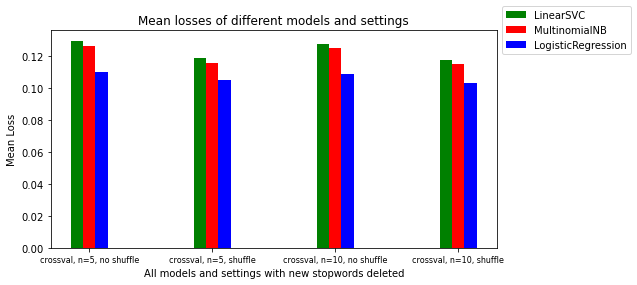

In [47]:
# Regroupement des résultats
xlabels = ["crossval, n=5, no shuffle", "crossval, n=5, shuffle", 
           "crossval, n=10, no shuffle", "crossval, n=10, shuffle"]
x = np.arange(4)

# Création du graphique
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)

# Mise en place des informations
ax.bar(x - 0.1, resultSVM, width=0.1, color='g', align='center', label="LinearSVC")
ax.bar(x, resultNB, width=0.1, color='r', align='center', label="MultinomialNB")
ax.bar(x + 0.1, resultLR, width=0.1, color='b', align='center', label="LogisticRegression")
ax.set_xlabel('All models and settings with new stopwords deleted', fontsize=10)
ax.set_ylabel('Mean Loss', fontsize=10)
plt.title('Mean losses of different models and settings')
plt.xticks(x, xlabels, fontsize=8)

# Mise en place de la légende
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# Affichage et sauvegarde
plt.savefig('plot/first_exp_cmp_fulldelete_nostemming_newstopwords.png', bbox_inches='tight')

## Troisième campagne d'expériences

### Recherche des meilleurs paramètres par GridSearch

On ne peut pas essayer chaque combinaison de paramètres à la main, il faut donc mettre en place un GridSearch avec tous les paramètres utilisés afin de trouver la meilleure.

On crée un dictionnaire allant contenir tous les champs de paramètres et valeurs possibles.

In [48]:
# Paramètres spécifiques
param_grid_clf = {'alpha': [0.1,0.2,0.25,0.5,0.75,0.8,1]}
param_grid_svc = {'max_iter': [1000,1500,2000], 
                  'C': [0,1,3,5,10,20,40,60,80,100]}
param_grid_lin = {'max_iter' :[1000,2000,3000,4000,5000]}

stopsWordsUP = cachedStopWords + newSW

# Création des Vectorizer
# CountVectorizer
vectorizerC_pres = CountVectorizer(max_features=10000)
vectorizerC_presSW = CountVectorizer(max_features=10000, stop_words=stopsWordsUP)
vectorizerC_pres1G = CountVectorizer(max_features=10000, ngram_range=(1,1))
vectorizerC_presSW1G = CountVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(1,1))
vectorizerC_pres2G = CountVectorizer(max_features=10000, ngram_range=(2,2))
vectorizerC_presSW2G = CountVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(2,2))
vectorizerC_pres12G = CountVectorizer(max_features=10000, ngram_range=(1,2))
vectorizerC_presSW12G = CountVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(2,2))
vectorizerC_pres13G = CountVectorizer(max_features=10000, ngram_range=(1,3))
vectorizerC_presSW123G = CountVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(1,3))
vectorizerC_pres3G = CountVectorizer(max_features=10000, ngram_range=(3,3))
vectorizerC_presSW3G = CountVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(3,3))

vectorizerTFIDF_pres = TfidfVectorizer(max_features=10000)
vectorizerTFIDF_presSW = TfidfVectorizer(max_features=10000, stop_words=stopsWordsUP)
vectorizerTFIDF_pres1G = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
vectorizerTFIDF_presSW1G = TfidfVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(1,1))
vectorizerTFIDF_pres2G = TfidfVectorizer(max_features=10000, ngram_range=(2,2))
vectorizerTFIDF_presSW2G = TfidfVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(2,2))
vectorizerTFIDF_pres12G = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizerTFIDF_presSW12G = TfidfVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(1,2))
vectorizerTFIDF_pres13G = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
vectorizerTFIDF_presSW123G = TfidfVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(1,3))
vectorizerTFIDF_pres3G = TfidfVectorizer(max_features=10000, ngram_range=(3,3))
vectorizerTFIDF_presSW3G = TfidfVectorizer(max_features=10000, stop_words=stopsWordsUP, ngram_range=(3,3))


vectorizers = {'vectorizerC_pres' : vectorizerC_pres, 'vectorizerC_presSW' : vectorizerC_presSW,
               'vectorizerC_pres1G' : vectorizerC_pres1G, 'vectorizerC_presSW1G' : vectorizerC_presSW1G,
               'vectorizerC_pres2G' : vectorizerC_pres2G, 'vectorizerC_presSW2G' : vectorizerC_presSW2G,
               'vectorizerC_pres12G' : vectorizerC_pres12G, 'vectorizerC_presSW12G' : vectorizerC_presSW12G,
               'vectorizerC_pres13G' : vectorizerC_pres13G, 'vectorizerC_presSW123G' : vectorizerC_presSW123G,
               'vectorizerC_pres3G' : vectorizerC_pres3G, 'vectorizerC_presSW3G' : vectorizerC_presSW3G,
               
               'vectorizerTFIDF_pres' : vectorizerTFIDF_pres, 'vectorizerTFIDF_presSW' : vectorizerTFIDF_presSW,
               'vectorizerTFIDF_pres1G' : vectorizerTFIDF_pres1G, 'vectorizerTFIDF_presSW1G' : vectorizerTFIDF_presSW1G,
               'vectorizerTFIDF_pres2G' : vectorizerTFIDF_pres2G, 'vectorizerTFIDF_presSW2G' : vectorizerTFIDF_presSW2G,
               'vectorizerTFIDF_pres12G' : vectorizerTFIDF_pres12G, 'vectorizerTFIDF_presSW12G' : vectorizerTFIDF_presSW12G,
               'vectorizerTFIDF_pres13G' : vectorizerTFIDF_pres13G, 'vectorizerTFIDF_presSW123G' : vectorizerTFIDF_presSW123G,
               'vectorizerTFIDF_pres3G' : vectorizerTFIDF_pres3G, 'vectorizerTFIDF_presSW3G' : vectorizerTFIDF_presSW3G}

# Ensemble des modèles
all_models = {clf:param_grid_clf, svc:param_grid_svc, lin:param_grid_lin}

Les combinaisons de paramètres et les vectorizers maintenant créés, on peut s'attaquer à la réalisation du GridSearch.

In [49]:
# Données utilisées
appX = appdata[0]
Xpres = ut.transform(appX, punc=True, nb=True)
Ypres = appY

# Dictionnaire de précision
accuracys = {}

# On crée des listes vides
for v in vectorizers:
    accuracys[v] = []
    
# GridSearch
for vname in vectorizers:
    v = vectorizers[vname]
    
    print("Work on vectorizer => ",vname)
    vectPres = v.fit_transform(Xpres)
    for m in all_models :
        print("\tWith => ",m)
        grid_cv = GridSearchCV(m, all_models[m], n_jobs=-1, cv=5, scoring='f1')
        grid_cv.fit(vectPres, Ypres)
        accuracys[vname].append((grid_cv.best_score_, grid_cv.best_params_))

Work on vectorizer =>  vectorizerC_pres
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_presSW
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_pres1G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_presSW1G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_pres2G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_presSW2G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_pres12G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_presSW12G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_pres13G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_presSW123G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_pres3G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerC_presSW3G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_pres
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_presSW
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_pres1G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_presSW1G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_pres2G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_presSW2G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Work on vectorizer =>  vectorizerTFIDF_pres12G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_presSW12G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_pres13G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_presSW123G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_pres3G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)
Work on vectorizer =>  vectorizerTFIDF_presSW3G
	With =>  MultinomialNB()
	With =>  LinearSVC()


/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/almehdikrisni/opt/anaconda3/envs/KrisniEnv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

	With =>  LogisticRegression(max_iter=1000)


In [50]:
accuracys

{'vectorizerC_pres': [(0.9306006539296137, {'alpha': 0.1}),
  (0.9290982988797936, {'C': 1, 'max_iter': 2000}),
  (0.9424636839020467, {'max_iter': 1000})],
 'vectorizerC_presSW': [(0.9297799440055629, {'alpha': 0.1}),
  (0.9234794121443312, {'C': 1, 'max_iter': 1000}),
  (0.9362420308077242, {'max_iter': 1000})],
 'vectorizerC_pres1G': [(0.9306006539296137, {'alpha': 0.1}),
  (0.9291086885283697, {'C': 1, 'max_iter': 1500}),
  (0.9424636839020467, {'max_iter': 1000})],
 'vectorizerC_presSW1G': [(0.9297799440055629, {'alpha': 0.1}),
  (0.9234794121443312, {'C': 1, 'max_iter': 1000}),
  (0.9362420308077242, {'max_iter': 1000})],
 'vectorizerC_pres2G': [(0.928518526483807, {'alpha': 0.1}),
  (0.923476020538026, {'C': 1, 'max_iter': 1000}),
  (0.9395469840867626, {'max_iter': 1000})],
 'vectorizerC_presSW2G': [(0.9245932726993278, {'alpha': 1}),
  (0.9235589460390369, {'C': 1, 'max_iter': 1000}),
  (0.9315111434538945, {'max_iter': 1000})],
 'vectorizerC_pres12G': [(0.9177320625227134, {'

### Analyse des données obtenues suite au GridSearch

In [51]:
valuesNB = []
valuesSVC = []
valuesLR = []

paramsNB = []
paramsSVC = []
paramsLR = []

for a in accuracys:
    list_accu = accuracys[a]
    
    valuesNB.append(list_accu[0][0])    
    valuesSVC.append(list_accu[1][0])    
    valuesLR.append(list_accu[2][0])
    
    paramsNB.append(list_accu[0][1])    
    paramsSVC.append(list_accu[1][1])    
    paramsLR.append(list_accu[2][1])

In [52]:
d = {'MultinomialB': valuesNB, 'MultinomialB_Params': paramsNB, 'SVC': valuesSVC, 'SVC_params': paramsSVC, 'LinearRegression' : valuesLR, 'LR_params' : paramsLR}
pd_analyse = pd.DataFrame(data=d, index=list(accuracys.keys()))

d2 = {'MultinomialB': valuesNB, 'SVC': valuesSVC, 'LinearRegression' : valuesLR}
pd_analyse_score_only = pd.DataFrame(data=d2, index=list(accuracys.keys()))

pd_analyse

,MultinomialB,MultinomialB_Params,SVC,SVC_params,LinearRegression,LR_params
vectorizerC_pres,0.930601,{'alpha': 0.1},0.929098,"{'C': 1, 'max_iter': 2000}",0.942464,{'max_iter': 1000}
vectorizerC_presSW,0.929780,{'alpha': 0.1},0.923479,"{'C': 1, 'max_iter': 1000}",0.936242,{'max_iter': 1000}
vectorizerC_pres1G,0.930601,{'alpha': 0.1},0.929109,"{'C': 1, 'max_iter': 1500}",0.942464,{'max_iter': 1000}
vectorizerC_presSW1G,0.929780,{'alpha': 0.1},0.923479,"{'C': 1, 'max_iter': 1000}",0.936242,{'max_iter': 1000}
vectorizerC_pres2G,0.928519,{'alpha': 0.1},0.923476,"{'C': 1, 'max_iter': 1000}",0.939547,{'max_iter': 1000}
vectorizerC_presSW2G,0.924593,{'alpha': 1},0.923559,"{'C': 1, 'max_iter': 1000}",0.931511,{'max_iter': 1000}
vectorizerC_pres12G,0.917732,{'alpha': 0.1},0.925994,"{'C': 1, 'max_iter': 1500}",0.942881,{'max_iter': 1000}
vectorizerC_presSW12G,0.924593,{'alpha': 1},0.923559,"{'C': 1, 'max_iter': 1000}",0.931511,{'max_iter': 1000}
vectorizerC_pres13G,0.913290,{'alpha': 0.1},0.926683,"{'C': 1, 'max_iter': 1500}",0.943055,{'max_iter': 1000}
vectorizerC_presSW123G,0.927568,{'alpha': 0.1},0.923480,"{'C': 1, 'max_iter': 1000}",0.936982,{'max_iter': 1000}


In [53]:
sc_countV = pd_analyse_score_only.head(12).to_numpy()
sc_TfidfV = pd_analyse_score_only.tail(12).to_numpy()
sc_ecart = sc_countV - sc_TfidfV

In [54]:
pd_ecart = pd.DataFrame(data=sc_ecart, index=np.arange(12)).rename(columns={0 : 'NB', 1 : 'SVC', 2 : 'LR'}, index={0:'movies',1:'moviesSW',2 : 'movies1G',3 : 'moviesSW1G',4 : 'movies2G',5 : 'moviesSW2G',6 : 'movies12G',7 : 'moviesSW12G',8 : 'movies3G',9 : 'moviesSW3G',10 : 'movies123G',11 : 'moviesSW123G'})
pd_ecart

,NB,SVC,LR
movies,-0.005767,-0.012607,0.000232
moviesSW,-0.004848,-0.010516,0.000078
movies1G,-0.005767,-0.012597,0.000232
moviesSW1G,-0.004848,-0.010516,0.000078
movies2G,-0.011305,-0.013659,0.000508
moviesSW2G,-0.006158,-0.002980,0.000672
movies12G,-0.023319,-0.018167,-0.000833
moviesSW12G,-0.011173,-0.010374,-0.005086
movies3G,-0.027344,-0.016875,-0.000677
moviesSW3G,-0.008244,-0.010543,0.000350


In [55]:
index_all_transform = list(pd_ecart.index)

In [56]:
valueSVC = pd_analyse_score_only.tail(12).iloc[:,1]
valueNB = pd_analyse_score_only.tail(12).iloc[:,0]
valueLR = pd_analyse_score_only.head(12).iloc[:,1]

In [57]:
valueSVCwithSW = []
valueSVCwithoutSW = []
valueNBwithSW = []
valueNBwithoutSW = []
valueLRwithSW = []
valueLRwithoutSW = []

for i in range(len(valueSVC)):
    if (i%2 == 0):
        valueSVCwithSW.append(1-valueSVC[i])        
        valueNBwithSW.append(1-valueNB[i])        
        valueLRwithSW.append(1-valueLR[i])        
    else:
        valueSVCwithoutSW.append(1-valueSVC[i])
        valueNBwithoutSW.append(1-valueNB[i])
        valueLRwithoutSW.append(1-valueLR[i])

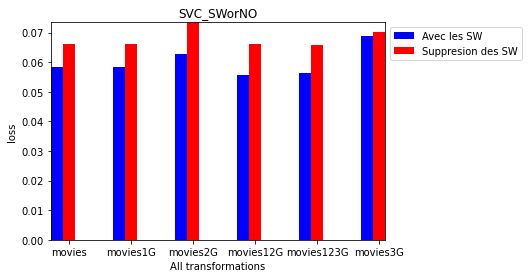

In [58]:
transf = ['movies', 'movies1G', 'movies2G', 'movies12G', 'movies123G', 'movies3G']

x = np.arange(6)

plt.figure()
ax = plt.subplot(111)
ax.bar(x-0.2, valueSVCwithSW, width=0.2, color='b', align='center', label="Avec les SW")
ax.bar(x, valueSVCwithoutSW, width=0.2, color='r', align='center', label="Suppresion des SW")
ax.set_xlabel('All transformations', fontsize=10)
ax.set_ylabel('loss', fontsize=10)
plt.title('SVC_SWorNO')
plt.xticks(x,transf)
plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
ax.autoscale(tight=True)
plt.savefig('plot/SVC_SWorNO.png')

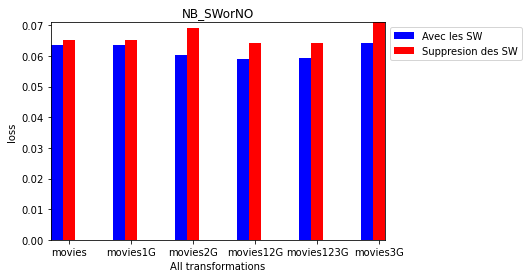

In [59]:
plt.figure()
ax = plt.subplot(111)
ax.bar(x-0.2, valueNBwithSW, width=0.2, color='b', align='center', label="Avec les SW")
ax.bar(x, valueNBwithoutSW, width=0.2, color='r', align='center', label="Suppresion des SW")
ax.set_xlabel('All transformations', fontsize=10)
ax.set_ylabel('loss', fontsize=10)
plt.xticks(x,transf)
plt.title('NB_SWorNO')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
ax.autoscale(tight=True)
plt.savefig('plot/NB_SWorNO.png')

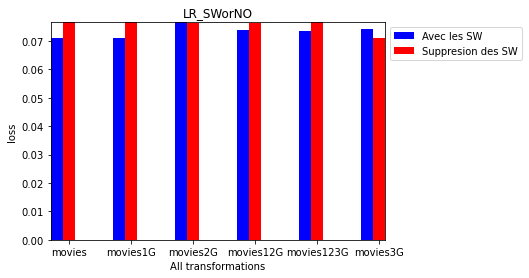

In [60]:
plt.figure()
ax = plt.subplot(111)
ax.bar(x-0.2, valueLRwithSW, width=0.2, color='b', align='center', label="Avec les SW")
ax.bar(x, valueLRwithoutSW, width=0.2, color='r', align='center', label="Suppresion des SW")
ax.set_xlabel('All transformations', fontsize=10)
ax.set_ylabel('loss', fontsize=10)
plt.xticks(x,transf)
plt.title('LR_SWorNO')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
ax.autoscale(tight=True)
plt.savefig('plot/LR_SWorNO.png')

In [61]:
nogram = [valueLRwithSW[0], valueNBwithSW[0], valueSVCwithSW[0]]
uni_gram = [valueLRwithSW[1], valueNBwithSW[1], valueSVCwithSW[1]]
deux_gram = [valueLRwithSW[2], valueNBwithSW[2], valueSVCwithSW[2]]
uni_deux_grams = [valueLRwithSW[3], valueNBwithSW[3], valueSVCwithSW[3]]
tri_grams = [valueLRwithSW[4], valueNBwithSW[4], valueSVCwithSW[4]]
uni_deux_tri_grams = [valueLRwithSW[5], valueNBwithSW[5], valueSVCwithSW[5]]

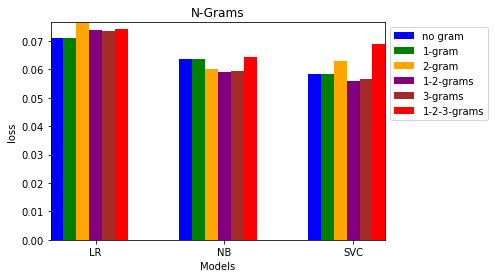

In [62]:
xgrams = np.arange(3)

plt.figure()
ax = plt.subplot(111)
ax.bar(xgrams-0.3, nogram, width=0.1, color='b', align='center', label="no gram")
ax.bar(xgrams-0.2, uni_gram, width=0.1, color='g', align='center', label="1-gram")
ax.bar(xgrams-0.1, deux_gram, width=0.1, color='orange', align='center', label="2-gram")
ax.bar(xgrams, uni_deux_grams, width=0.1, color='purple', align='center', label="1-2-grams")
ax.bar(xgrams+0.1, tri_grams, width=0.1, color='brown', align='center', label="3-grams")
ax.bar(xgrams+0.2, uni_deux_tri_grams, width=0.1, color='r', align='center', label="1-2-3-grams")
ax.set_xlabel('Models', fontsize=10)
ax.set_ylabel('loss', fontsize=10)
plt.xticks(xgrams,['LR','NB','SVC'])
plt.title('N-Grams')


plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
ax.autoscale(tight=True)
plt.savefig('plot/N-Grams.png')

In [63]:
nogramSW = [valueLRwithoutSW[0], valueNBwithoutSW[0], valueSVCwithoutSW[0]]
uni_gramSW = [valueLRwithoutSW[1], valueNBwithoutSW[1], valueSVCwithoutSW[1]]
deux_gramSW = [valueLRwithoutSW[2], valueNBwithoutSW[2], valueSVCwithoutSW[2]]
uni_deux_gramsSW = [valueLRwithoutSW[3], valueNBwithoutSW[3], valueSVCwithoutSW[3]]
tri_gramsSW = [valueLRwithoutSW[4], valueNBwithoutSW[4], valueSVCwithoutSW[4]]
uni_deux_tri_gramsSW = [valueLRwithoutSW[5], valueNBwithoutSW[5], valueSVCwithoutSW[5]]

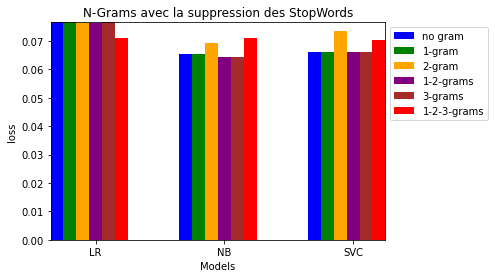

In [64]:
xgramsSW = np.arange(3)

plt.figure()
ax = plt.subplot(111)
ax.bar(xgramsSW-0.3, nogramSW, width=0.1, color='b', align='center', label="no gram")
ax.bar(xgramsSW-0.2, uni_gramSW, width=0.1, color='g', align='center', label="1-gram")
ax.bar(xgramsSW-0.1, deux_gramSW, width=0.1, color='orange', align='center', label="2-gram")
ax.bar(xgramsSW, uni_deux_gramsSW, width=0.1, color='purple', align='center', label="1-2-grams")
ax.bar(xgramsSW+0.1, tri_gramsSW, width=0.1, color='brown', align='center', label="3-grams")
ax.bar(xgramsSW+0.2, uni_deux_tri_gramsSW, width=0.1, color='r', align='center', label="1-2-3-grams")
ax.set_xlabel('Models', fontsize=10)
ax.set_ylabel('loss', fontsize=10)
plt.xticks(xgrams,['LR','NB','SVC'])
plt.title('N-Grams avec la suppression des StopWords')


plt.legend()
plt.legend(bbox_to_anchor=(1, 1))
ax.autoscale(tight=True)
plt.savefig('plot/N-GramsSW.png')

### Création du fichier de prédiction

Après analyse de nos résultats finaux, nous en avons donc conclu que le modèle optimal est le SVC utilisant un VectorizerTDIDF (1-2gram et conservation des stopwords), avec C = 1 et 1000 itérations maximales.

In [65]:
# Importation de votre librairie iads
import sys
sys.path.append('../')

# Iportation de utils
from iads import utils as ut

# Récupération des données
appdata = ut.load_pres("AFDpresidentutf8/corpus.tache1.learn.utf8")
appX = appdata[0]
appY = appdata[1]

# Création du vecteur de données
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm


vectFinal = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [66]:
# On crée les données
Xpres = ut.transform(appX, punc=True)
Xpres = vectFinal.fit_transform(Xpres)
Ypres = appY

In [67]:
# On entraîne le modèle sur les données
svcPredict = svm.LinearSVC(max_iter=1000, C=1)
svcPredict.fit(Xpres, Ypres)

LinearSVC(C=1)

In [68]:
# On s'intéresse maintenant aux données que l'on doit prédire
import numpy as np

path = "AFDpresidentutf8/corpus.tache1.test.utf8"
f = open(path,encoding="utf8")
pres_tests = np.array(f.readlines())

In [69]:
# On retire la ponctuation et les nombres des données
pres_tests = ut.transform(pres_tests, punc=True, nb=True)

In [70]:
# On met sous forme vecteur les données à tester et on réalise la prédiction
vecPresTest = vectFinal.fit_transform(pres_tests)
predicts = svcPredict.predict(vecPresTest)

In [71]:
# On écrit dans un fichier le résultat
with open('predictPresident.txt', 'w') as f:
    for p in predicts:
        f.write(str(p)+'\n')

In [74]:
# Etude du nombre de prédictions pour chaque classe
countC = 0
countM = 0

with open('predictPresident.txt', 'r') as f :
    txt = f.readlines()
    for p in txt :
        pred = p.split()
        pred = pred[0]
        
        if (pred == '-1') :
            countM += 1
        elif (pred == '1') :
            countC += 1
        
print('On prédit', countC, 'phrases prononcées par Chirac.')        
print('On prédit', countM, 'phrases prononcées par Mitterrand.')

On prédit 26859 phrases prononcées par Chirac.
On prédit 303 phrases prononcées par Mitterrand.
